<a href="https://colab.research.google.com/github/EslamKampoza/machine-intelligence-paper-/blob/main/Extrasensory_SMOTE_orig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

from utilize.data import *
from utilize.transform import *
from utilize.feature_selection import *
from utilize.test import *


In [50]:
def score_function(y_test, y_pred, score = 'BA', W_test = None):

    mcm = []
    for i in range(y_test.shape[1]):
        if W_test is not None:
            cm = confusion_matrix(y_test[:,i].T, y_pred[:,i].T, sample_weight = W_test[:,i].T)
        else:
            cm = confusion_matrix(y_test[:,i].T, y_pred[:,i].T)
        cm = np.expand_dims(cm, axis = 0)
        mcm.append(cm)
    
    mcm = np.concatenate(mcm, axis = 0)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    BA = (sensitivity + specificity)/2
    accuracy = (tn + tp)/(tn + tp + fn + fp)

    sensitivity = np.sum(sensitivity)/sensitivity.shape[0]
    specificity = np.sum(specificity)/specificity.shape[0]
    BA = np.sum(BA)/BA.shape[0]
    accuracy = np.sum(accuracy)/accuracy.shape[0]

    if score == 'BA': 
        return BA
    else: 
        raise Exception('score not valid!')

In [51]:
# Load all the data from Extrasenory dataset
X, y, M, user_index, feature_names, label_names = load_all_data()

In [52]:
feature_index = [ 0,   1,   2,   4,   6,   7,   9,  12,  13,  16,  17,  18,  19,
        20,  22,  23,  24,  25,  26,  27,  28,  31,  32,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  49,  52,  53,
        54,  56,  58,  59,  60,  61,  62,  63,  65,  67,  68,  69,  71,
        72,  73,  74,  76,  77,  78,  79,  80,  81,  85,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 115, 116, 119, 120,
       121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 139, 140, 142, 144, 145, 146, 147, 148, 149, 150,
       151, 153, 154, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 170, 171, 172, 173, 176, 177, 178, 180, 181, 182, 183,
       185, 187, 188, 190, 192, 193, 194, 195, 196, 197, 198, 199, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 224]
X175 = X[:, feature_index]

In [53]:
# Only select body state label
target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']
#target_label = ["SITTING"]
# Use the last 5 user's data as test set
#test_uuid = list(range(56, 61))

# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('std_scaler', StandardScaler())
])

# Transform 
# 1. select target labels 
# 2. tansform feature matrix fill None with mean and do the normalization
# 3. Split train, validation and test set by ratio of 6:2:2
X_new, y_new, M_new = select_target_labels(X175, y, M, target_label, label_names, drop_all_zero = False)
X_new = pipeline.fit_transform(X_new, y_new)


In [54]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test, M_train, M_test = train_test_split(X_new, y_new, M_new, test_size = 0.2)

In [55]:
# To swap 0 and 1, simply do 
y_train_sampleweight = np.abs(1-M_train)

y_train_sw1D = np.zeros(y_train_sampleweight.shape[0])
for i in range(len(y_train_sw1D)):
    y_train_sw1D[i] = np.sum(y_train_sampleweight[i])/M_train.shape[1]

# To swap 0 and 1, simply do 
y_test_sampleweight = np.abs(1-M_test)

y_test_sw1D = np.zeros(y_test_sampleweight.shape[0])
for i in range(len(y_test_sw1D)):
    y_test_sw1D[i] = np.sum(y_test_sampleweight[i])/M_test.shape[1]

In [56]:
y_train11 = y_train_sw1D.reshape(len(y_train_sw1D),1)
y_test11 = y_test_sw1D.reshape(len(y_test_sw1D),1)

In [57]:
y_test1 = []
new_test_Data1 = []
for i in range(len(y_test)):
    for j in range(y_test.shape[1]):
        if y_test[i,j]:
             y_test1.append(j)
             new_test_Data1.append(X_test[i])

In [58]:
y_train1 = []
new_train_Data1 = []
for i in range(len(y_train)):
    for j in range(y_train.shape[1]):
        if y_train[i,j]:
             y_train1.append(j)
             new_train_Data1.append(X_train[i])

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler , MinMaxScaler

In [60]:
scaler = MinMaxScaler()
scaler.fit(new_train_Data1)
X_train = scaler.transform(new_train_Data1)
X_test = scaler.transform(new_test_Data1)

In [61]:
#encoding Labels

encoder = LabelEncoder()

#encoding test labels

encoder.fit(y_test1)
new_test_labels = encoder.transform(y_test1)

#encoding train labels

encoder.fit(y_train1)
new_train_labels = encoder.transform(y_train1)

In [62]:
from matplotlib import pyplot
def plot_confusion_matrix (cm, classes, normalize=False, title='Confusion Matrix', cmap=pyplot.cm.Blues,
                           decsnTreeClf=None):
    #This function prints and plots the confusion matrix.
    pyplot.imshow(cm,interpolation='nearest',cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks=np.arange(len(classes))
    pyplot.xticks(tick_marks,classes,rotation=45)
    pyplot.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j,i,cm[i,j],horizontalalignment="center", color="white" if cm[i,j]> thresh else "black" )

    pyplot.tight_layout()
    pyplot.ylabel('True Label')
    pyplot.xlabel('Predicted Label')
    pyplot.show()


In [70]:
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from sklearn.metrics import classification_report

In [72]:
sm = SMOTE(random_state = 2)
Data_res,labels_res = sm.fit_resample(X_train,new_train_labels)

In [73]:
unique,counts = np.unique(labels_res,return_counts = True)
dict(zip(unique,counts))

{0: 108984, 1: 108984, 2: 108984, 3: 108984, 4: 108984, 5: 108984}

In [74]:
clf2= KNeighborsClassifier(n_neighbors=4)
knnModel2 = clf2.fit(Data_res,labels_res)

In [75]:
X_test.shape

(61515, 175)

In [76]:
unique,counts = np.unique(new_test_labels,return_counts = True)
dict(zip(unique,counts))

{0: 21104, 1: 27372, 2: 4485, 3: 203, 4: 931, 5: 7420}

K-Nearest Neighbors Accuracy: 0.84469
Confusion matrix, without normalization
[[20239   334   171     5    17   338]
 [  966 21551  1976    82   377  2420]
 [   42   317  3556    32   117   421]
 [    1     6    26   162     2     6]
 [    2    27    61     2   808    31]
 [  193   691   707    27   157  5645]]


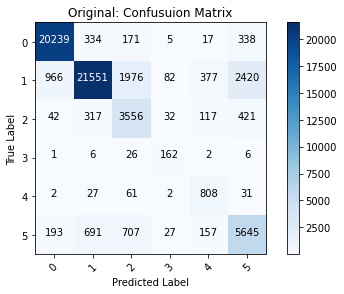

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     21104
           1       0.94      0.79      0.86     27372
           2       0.55      0.79      0.65      4485
           3       0.52      0.80      0.63       203
           4       0.55      0.87      0.67       931
           5       0.64      0.76      0.69      7420

    accuracy                           0.84     61515
   macro avg       0.69      0.83      0.74     61515
weighted avg       0.87      0.84      0.85     61515



In [77]:
import itertools
from sklearn.metrics import classification_report
y_te_pred2 = clf2.predict(X_test)#[1:10000,:])

acc2 = accuracy_score(new_test_labels,y_te_pred2)
print("K-Nearest Neighbors Accuracy: %.5f" %(acc2)) #.907
cfs=confusion_matrix(new_test_labels,y_te_pred2)
pyplot.figure()
class_names = encoder.classes_
plot_confusion_matrix(cfs,classes=class_names,title="Original: Confusuion Matrix")
print(classification_report(new_test_labels,y_te_pred2))

In [1]:
target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']
plot_confusion_matrix(cfs,classes=target_label,title="Original: Confusuion Matrix")

NameError: ignored